In [41]:
import numpy as np
import pandas as pd
from scipy.linalg import eigh
from tqdm.auto import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from qiskit import transpile
from qiskit.circuit.library import UnitaryGate
from qiskit_aer import Aer

import utils
# good seeds (9112001, 9112005)
np.random.seed(9112010)
np.set_printoptions(precision=5)

In [42]:
# consider 3 qubits
N   = 3

""" Build A matrix such that the Hamiltoninan has
    entries with both real and imaginary part 
    inside (-bound, bound)
"""
bound = 1
H = utils.get_random_H(N, bound)

evs, w = eigh(H)
w      = w.T
gs     = w[0] / np.linalg.norm(w[0]) # we need to normalize it because later we calculate eps
w_max  = w[np.argmax(np.abs(evs))] # select eigenvector that corresponds to the eigenvalue of maximum module
print(f"gs is w_max: {np.allclose(gs, w_max)}")

v_min = np.min(np.abs(evs))
v_max = np.max(np.abs(evs))
print(f"Smallest eigenvalue: {evs[0]:.5f}")
print(f"Biggest eigenvalue: {evs[-1]:.5f}")
print(f"Smallest eigenvalue in magnitude v_min = {v_min:.5f}")
print(f"Biggest eigenvalue in magnitude v_max = {v_max:.5f}")

gs is w_max: False
Smallest eigenvalue: -2.34569
Biggest eigenvalue: 2.49718
Smallest eigenvalue in magnitude v_min = 0.02496
Biggest eigenvalue in magnitude v_max = 2.49718


In [31]:
M_max    = 4
M_values = np.arange(1, M_max + 1)
n_points = 6
a_values = np.linspace(0, 1, n_points)

data = []

for M in tqdm(M_values):
    t = M / (2 * v_max) # moving along the straight line in the heatmap
    
    for a_0 in a_values:
        n_anc = 2 * M
        psi_0 = a_0 * gs + np.sqrt(1 - a_0 ** 2) * w_max
        psi_0 /= np.linalg.norm(psi_0)

        # print(f"Success between psi0 and w[1]: {np.abs(np.vdot(w[1], psi_0)) ** 2}")

        qc = utils.get_itimevol_circuit(N, M, H, t, psi_0)
        qc.save_statevector()

        aer_sim = Aer.get_backend("aer_simulator_statevector")
        qc_tp   = transpile(qc, backend=aer_sim)
        result  = aer_sim.run(qc_tp, shots=1).result()

        final_state_dict     = result.get_statevector(qc_tp).to_dict()
        final_state_sys_dict = {}

        for k, v in final_state_dict.items():
            if k[-n_anc:] == '0' * n_anc:
                k_new = k[:N]
                final_state_sys_dict[k_new] = v

        final_state_sys_list = [(k, v) for k, v in final_state_sys_dict.items()]
        final_state_sys_list = sorted(final_state_sys_list)
        final_state          = np.array([t[1] for t in final_state_sys_list])
        final_state          /= np.linalg.norm(final_state)

        eps = 1 - np.abs(np.vdot(gs, final_state)) ** 2
        data.append((M, a_0, eps))

100%|██████████| 4/4 [00:52<00:00, 13.01s/it]


    M  a_0           eps
0   1  0.0  1.000000e+00
1   1  0.2  8.272435e-01
2   1  0.4  5.115955e-01
3   1  0.6  2.618310e-01
4   1  0.8  1.009057e-01
5   1  1.0  0.000000e+00
6   2  0.0  1.000000e+00
7   2  0.2  4.885966e-01
8   2  0.4  1.728664e-01
9   2  0.6  6.609316e-02
10  2  0.8  2.190183e-02
11  2  1.0 -4.440892e-16
12  3  0.0  1.000000e+00
13  3  0.2  1.601033e-01
14  3  0.4  4.002953e-02
15  3  0.6  1.392359e-02
16  3  0.8  4.447847e-03
17  3  1.0 -4.440892e-16
18  4  0.0  1.000000e+00
19  4  0.2  3.663963e-02
20  4  0.4  8.251104e-03
21  4  0.6  2.809355e-03
22  4  0.8  8.906080e-04
23  4  1.0  0.000000e+00


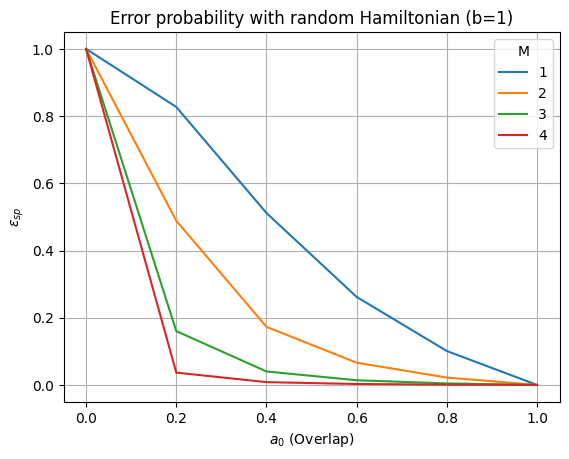

In [32]:
df = pd.DataFrame(data, columns=["M", "a_0", "eps"])
print(df)
sns.lineplot(df, x = "a_0", y = "eps", hue = "M", palette="tab10")
plt.xlabel(r'$a_0$ (Overlap)')
plt.ylabel(r'$\epsilon_{sp}$')
plt.title(f"Error probability with random Hamiltonian (b={bound})")
plt.grid()